# Set up the stage

Preliminary operations, useful to tackle the challenge

In [ ]:
# Explicitly print the variables: useful for debugging

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# Import all the necessary libraries and functions

import os

import tensorflow as tf
import numpy as np

import shutil

# Set the seed for random operations, in order to let all the experiments be reproducible

SEED = 1234

tf.random.set_seed(SEED)
np.random.seed(SEED)

# We get the current directory cwd ('/content') and the directory env, which contains the zip file and the notebook

cwd = os.getcwd()
env = '/content/drive/My Drive/ANNDL_Homeworks2/Andrea/Experiment_Final'

In [ ]:
# Mount Drive, in order to access to all folders and files in Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the dataset file

!unzip '/content/drive/My Drive/ANNDL_Homeworks2/Andrea/Experiment_Final/Development_Dataset.zip'

In [ ]:
# Unzip the additional file

!unzip '/content/drive/My Drive/ANNDL_Homeworks2/Andrea/Experiment_Final/Final_Dataset.zip'

In [ ]:
!ls '/content'

Development_Dataset  drive  sample_data  Test_Dev  Test_Final


# Dataset construction

Creation of the dataset data structure, useful for the training of the model

In [ ]:
# Use ImageDataGenerator to perform data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True  # If true, perform data augmentation

if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=5,
                                      zoom_range=0.1,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=5,
                                      zoom_range=0.1,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
else:
    img_data_gen = None
    mask_data_gen = None

In [ ]:
# Use this sligthly modified version of read_rgb_mask to convert RGB masks into 
# labels directly in the __getitem__ method

from PIL import Image

def read_rgb_mask(image):
    '''
    image: mask image
    Returns the numpy array containing target values
    '''
    
    mask_arr = np.array(image)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

In [ ]:
# This class inherits from tf.keras.utils.Sequence, in order to synthesize a customized generator for datasets

# We slightly modified the __getitem__ method, in order to convert the given masks (in RGB) to labels

from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  # self: like *this in C++
  # dataset_dir: address of the folder containing the complete dataset
  # which_subset: this function operates either on 'training' or 'validation'
  # img_generator: generator of images (mostly for data augmentation)
  # mask_generator: generator of images (mostly for data augmentation); for masks here
  # preprocessing_function: function that preprocesses each input
  # out_shape: shape of the output

  # return: a dataset generator (like the ones returned by flow_from_directory)

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  # self: like *this in C++

  # return: number of sample in the dataset

  def __len__(self):
    return len(self.subset_filenames)

  # self: like *this in C++
  # index: index of the image to be returned

  # return: 2 arrays (1 for the image, 1 for the mask)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.jpg'))
    mask = Image.open(os.path.join(self.dataset_dir, 'Annotations', curr_filename + '.png'))

    # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    mask_arr = read_rgb_mask(mask)

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
## Copy images and masks from Test_Dev to the relative subfolders of Development_Dataset, in order to exploit properly all the code we wrote for Challenge2

# Bipbip-Haricot

source_dir_images = '/content/Test_Dev/Bipbip/Haricot/Images'
source_dir_masks = '/content/Test_Dev/Bipbip/Haricot/Masks'

target_dir_images = '/content/Development_Dataset/Training/Bipbip/Haricot/Images'
target_dir_masks = '/content/Development_Dataset/Training/Bipbip/Haricot/Masks'

filenames = os.listdir(source_dir_images)

for filename in filenames:
  shutil.copy2(os.path.join(source_dir_images, filename), target_dir_images)

filenames = os.listdir(source_dir_masks)

for filename in filenames:
  shutil.copy2(os.path.join(source_dir_masks, filename), target_dir_masks)

# Bipbip-Mais

source_dir_images = '/content/Test_Dev/Bipbip/Mais/Images'
source_dir_masks = '/content/Test_Dev/Bipbip/Mais/Masks'

target_dir_images = '/content/Development_Dataset/Training/Bipbip/Mais/Images'
target_dir_masks = '/content/Development_Dataset/Training/Bipbip/Mais/Masks'

filenames = os.listdir(source_dir_images)

for filename in filenames:
  shutil.copy2(os.path.join(source_dir_images, filename), target_dir_images)

filenames = os.listdir(source_dir_masks)

for filename in filenames:
  shutil.copy2(os.path.join(source_dir_masks, filename), target_dir_masks)

In [ ]:
# In order to use the classes provided, we created and run data_manipulation function, which:

  # Renames "Masks" folder in "Annotations"
  # Creates a "Splits" folder
  # Creates the necessary txt files for dataset splitting: "train.txt" and "val.txt"

# Function definition:

import random

def data_manipulation(dataset_dir, validation_split):

  # In the folder, rename "Masks" in "Annotations"

  mask_path = os.path.join(dataset_dir, 'Masks')
  new_mask_path = os.path.join(dataset_dir, 'Annotations')

  if not os.path.exists(new_mask_path):
    os.rename(mask_path, new_mask_path)

  # Generate "Splits" directory

  target_path = os.path.join(dataset_dir, 'Splits')

  if not os.path.exists(target_path):
    os.makedirs(target_path)

  images_dir = os.path.join(dataset_dir, 'Images')

  # Create the "train.txt" and "val.txt" files

  f_train = open(os.path.join(target_path,"train.txt"), "w+")
  f_val = open(os.path.join(target_path,"val.txt"), "w+")

  # Create the list of images names (shuffle names with a fixed SEED to ensure reproducibility)

  names_list = os.listdir(images_dir)
  names_list = sorted(names_list)

  random.Random(SEED).shuffle(names_list)

  total_N = len(names_list)
  val_N = int((1-validation_split)*total_N)

  # Assign filenames in "train.txt"

  for count in range(0, val_N):
    name = names_list[count]
    name = name.replace(".jpg", "")
    f_train.write(name + "\n")
  f_train.close()

  # Assign filenames in "val.txt"

  for count in range(val_N, total_N):
    name = names_list[count]
    name = name.replace(".jpg", "")
    f_val.write(name + "\n")
  f_val.close()

In [ ]:
# Run the data_manipulation function just created, for each crop

dataset_name = 'Bipbip'

validation_split = 0.1

# Haricot

crop_name = 'Haricot'

dataset_dir = os.path.join('/content/Development_Dataset/Training', dataset_name, crop_name)

data_manipulation(dataset_dir, validation_split)

# Mais

crop_name = 'Mais'

dataset_dir = os.path.join('/content/Development_Dataset/Training', dataset_name, crop_name)

data_manipulation(dataset_dir, validation_split)

In [ ]:
!ls '/content/Development_Dataset/Training/Bipbip/Haricot'
!ls '/content/Development_Dataset/Training/Bipbip/Haricot/Splits'

In [ ]:
!ls '/content/Development_Dataset/Training/Bipbip/Mais'
!ls '/content/Development_Dataset/Training/Bipbip/Mais/Splits'

In [ ]:
# Check the splitting between training and validation dataset for Haricot

from shutil import copyfile
copyfile(os.path.join('/content/Development_Dataset/Training/Bipbip/Haricot', 'Splits',"train.txt"), os.path.join(env,'our_train_Haricot.txt'))
copyfile(os.path.join('/content/Development_Dataset/Training/Bipbip/Haricot', 'Splits',"val.txt"), os.path.join(env,'our_val_Haricot.txt'))

In [ ]:
# Check the splitting between training and validation dataset for Mais

from shutil import copyfile
copyfile(os.path.join('/content/Development_Dataset/Training/Bipbip/Mais', 'Splits',"train.txt"), os.path.join(env,'our_train_Mais.txt'))
copyfile(os.path.join('/content/Development_Dataset/Training/Bipbip/Mais', 'Splits',"val.txt"), os.path.join(env,'our_val_Mais.txt'))

In [ ]:
# Use the class defined before to create customized dataset generators, for each crop

from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 1184
img_w = 1184

bs_train = 9
bs_val = 3

# Haricot generators

Haricot_dataset = CustomDataset('/content/Development_Dataset/Training/Bipbip/Haricot', 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input, out_shape=[img_w, img_h])

Haricot_dataset_valid = CustomDataset('/content/Development_Dataset/Training/Bipbip/Haricot', 'validation', 
                              preprocessing_function=preprocess_input, out_shape=[img_w, img_h])

# Mais generators

Mais_dataset = CustomDataset('/content/Development_Dataset/Training/Bipbip/Mais', 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input, out_shape=[img_w, img_h])

Mais_dataset_valid = CustomDataset('/content/Development_Dataset/Training/Bipbip/Mais', 'validation', 
                              preprocessing_function=preprocess_input, out_shape=[img_w, img_h])


# Use the generators just created to construct training and validation datasets separately for each crop of the team

# Haricot datasets

Haricot_train_dataset = tf.data.Dataset.from_generator(lambda: Haricot_dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

Haricot_train_dataset = Haricot_train_dataset.batch(bs_train)

Haricot_valid_dataset = tf.data.Dataset.from_generator(lambda: Haricot_dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

Haricot_valid_dataset = Haricot_valid_dataset.batch(bs_val)

# Mais datasets

Mais_train_dataset = tf.data.Dataset.from_generator(lambda: Mais_dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

Mais_train_dataset = Mais_train_dataset.batch(bs_train)

Mais_valid_dataset = tf.data.Dataset.from_generator(lambda: Mais_dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

Mais_valid_dataset = Mais_valid_dataset.batch(bs_val)

# Eventually concatenate the two train and valid datasets to create the final ones

train_dataset = Haricot_train_dataset.concatenate(Mais_train_dataset)

train_dataset = train_dataset.repeat()

valid_dataset = Haricot_valid_dataset.concatenate(Mais_valid_dataset)

valid_dataset = valid_dataset.repeat()

In [ ]:
# Run this function (found on StackOverflow) to denormalize the image wrt the vgg preprocessing

def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
# Perform the test of the data generator

import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class

evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)

[0. 1. 2.]


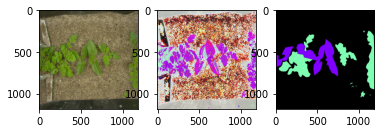

In [ ]:
fig, ax = plt.subplots(1, 3)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img_denormalized = deprocess_img(augmented_img.numpy())

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img_denormalized))
ax[1].imshow(np.uint8(augmented_img))
ax[2].imshow(np.uint8(target_img))

plt.show()

# Model creation
### Encoder-Decoder

In [ ]:
# We import the vgg cnn, and freeze all its layers

vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

for layer in vgg.layers:
  layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
# Create a proper model for this task

depth=5 
start_f = 90
num_classes=3

model = tf.keras.Sequential()

# Encoder

model.add(vgg)

# Decoder

for i in range(depth):
    model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
    model.add(tf.keras.layers.Conv2D(filters=start_f,
                                     kernel_size=(3, 3),
                                     strides=(1, 1),
                                     padding='same'))
    model.add(tf.keras.layers.ReLU())
    start_f = start_f // 2

# Prediction Layer

model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                 kernel_size=(1, 1),
                                 strides=(1, 1),
                                 padding='same',
                                 activation='softmax'))

# Visualize created model as a table

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 37, 37, 512)       14714688  
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 74, 74, 512)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 74, 74, 90)        414810    
_________________________________________________________________
re_lu (ReLU)                 (None, 74, 74, 90)        0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 148, 148, 90)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 45)      36495     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 148, 148, 45)      0

# Model preparation and training

In [ ]:
# Set the proper optimization params

# Loss

loss = tf.keras.losses.SparseCategoricalCrossentropy()

# learning rate

lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Use the given function to compute intersection over union for each class in the batch.
# Compute the final iou as the mean over classes

def meanIoU(y_true, y_pred):

    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0

      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Set validation metrics

metrics = ['accuracy', meanIoU]

# Compile Model

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# We set the proper callbacks for training

# Create the folder for the experiments

from datetime import datetime

exps_dir = os.path.join(env, 'multiclass_segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

# Create the folder for the current experiment

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint

ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True,
                                                   save_best_only=False)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard

tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping

early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    callbacks.append(es_callback)

In [ ]:
# Perform the training of the model

model.fit(x=train_dataset,
          epochs=50,  #### set repeat in training dataset
          steps_per_epoch=(len(Haricot_dataset)+len(Mais_dataset)) // bs_train,
          validation_data=valid_dataset,
          validation_steps=(len(Haricot_dataset_valid)+len(Mais_dataset_valid)) // bs_val, 
          callbacks=callbacks)

Epoch 1/50
20/20 [==============================] - 184s 8s/step - loss: 0.3409 - accuracy: 0.8951 - meanIoU: 0.1087 - val_loss: 0.1525 - val_accuracy: 0.9450 - val_meanIoU: 0.3077
Epoch 2/50
20/20 [==============================] - 152s 8s/step - loss: 0.1655 - accuracy: 0.9278 - meanIoU: 0.3112 - val_loss: 0.1405 - val_accuracy: 0.9429 - val_meanIoU: 0.2888
Epoch 3/50
20/20 [==============================] - 151s 8s/step - loss: 0.1546 - accuracy: 0.9285 - meanIoU: 0.3147 - val_loss: 0.1221 - val_accuracy: 0.9535 - val_meanIoU: 0.3429
Epoch 4/50
20/20 [==============================] - 152s 8s/step - loss: 0.1417 - accuracy: 0.9370 - meanIoU: 0.3559 - val_loss: 0.1171 - val_accuracy: 0.9548 - val_meanIoU: 0.3613
Epoch 5/50
20/20 [==============================] - 150s 8s/step - loss: 0.1429 - accuracy: 0.9342 - meanIoU: 0.3837 - val_loss: 0.1177 - val_accuracy: 0.9583 - val_meanIoU: 0.4006
Epoch 6/50
20/20 [==============================] - 155s 8s/step - loss: 0.1413 - accuracy: 0.9

# Model test

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/drive/My Drive/ANNDL_Homeworks2/Andrea/Experiment_Final/multiclass_segmentation_experiments'

In [ ]:
# Load chosen model (we chose the 27th epoch, that ensures the best balance between val_loss and val_meanIoU)

model.load_weights(os.path.join(env, 'multiclass_segmentation_experiments', 'CNN_Jan19_07-27-48', 'ckpts', 'cp_27.ckpt'))

In [ ]:
# Perform the test of the model

%matplotlib inline

iterator = iter(valid_dataset)

(1, 1184, 1184, 3)

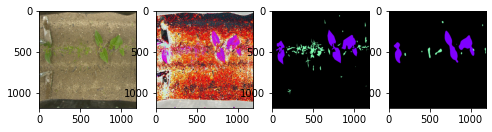

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
img_denormalized = deprocess_img(image.numpy())

target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(img_denormalized))
ax[1].imshow(np.uint8(image))
ax[2].imshow(np.uint8(target_img))
ax[3].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)

# Generate prediction

In [ ]:
# Load chosen model

model.load_weights(os.path.join(env, 'multiclass_segmentation_experiments', 'CNN_Jan19_07-27-48', 'ckpts', 'cp_27.ckpt'))

In [ ]:
def rle_encode(img):
  '''
  img: numpy array, 1 - foreground, 0 - background
  Returns run length as string formatted
  '''
  pixels = img.flatten()
  pixels = np.concatenate([[0], pixels, [0]])
  runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
  runs[1::2] -= runs[::2]
  return ' '.join(str(x) for x in runs)

In [ ]:
import PIL
import json
import cv2

# Set the subgroups of folders that must be tested

teams = ('Bipbip','Pead','Roseau','Weedelec')
crops = ('Haricot','Mais')

submission_dict = {}

for team in teams:
  for crop in crops:

    # Set the image folder for testing

    test_dir = os.path.join('/content/Test_Final', team, crop, 'Images')

    # Get the list of image names to be tested
 
    names_list = os.listdir(test_dir)
    names_list = sorted(names_list)

    # Fill the dictionary with all the necessary informations

    for image_name in names_list:
  
      # Open image

      image = Image.open(os.path.join(test_dir, image_name))

      initial_size = list(image.size)
      image = image.resize([img_w, img_h])

      # Create a tensor from each image

      img_arr = np.array(image)
      img_arr = preprocess_input(img_arr)

      # Generate the prediction
      
      model_output = model.predict(x=tf.expand_dims(img_arr, 0))
      mask_arr = tf.argmax(model_output, -1)
      mask_arr = np.array(mask_arr[0, ...])

      mask_arr = cv2.resize(mask_arr, dsize=(initial_size[0], initial_size[1]), interpolation=cv2.INTER_NEAREST)
  
      # Add to the dictionary

      img_name = image_name.replace('.jpg', '').replace('.png', '')
 
      submission_dict[img_name] = {}
      submission_dict[img_name]['shape'] = mask_arr.shape
      submission_dict[img_name]['team'] = team
      submission_dict[img_name]['crop'] = crop
      submission_dict[img_name]['segmentation'] = {}
  
      # RLE encoding

      # crop
      rle_encoded_crop = rle_encode(mask_arr == 1)
      # weed
      rle_encoded_weed = rle_encode(mask_arr == 2)  
  
      # Fill the dictionary with segmentation infos

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

      image.close()

# Create json file

with open(os.path.join(env, 'submission.json'), 'w') as f:
  json.dump(submission_dict, f)